## Libraries 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import warnings
import sys
import datetime

from IPython.display import display
from kmodes.kmodes import KModes

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import silhouette_score, calinski_harabasz_score, accuracy_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

warnings.filterwarnings("ignore")

# <font color=blue>*Data Preprocessing*</font>

## Import Data 

In [3]:
#read the .csv file
#change the data-types for columns such as "InvoiceNo", "CustomerID"
df = pd.read_csv("data.csv",encoding='ISO-8859-1',dtype={'InvoiceNo':'str','CustomerID':'str'})
display(df.head())

#convert "InvoiceDate" to datetime object
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("\nDATA INFORMATION:")
print(df.info())


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom



DATA INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB
None


## <font color=red>**NULL Values**</font>

In [4]:
# find and display null values and % of this in the dataset
df.isnull().sum().values

#dict and dataFrame to diplay null values
nullv_dict = {'Attributes': df.columns,
              'Null Values': df.isnull().sum().values,
              'NaN(%)': (df.isnull().sum().values/df.shape[0])*100}
nullv_df = pd.DataFrame(nullv_dict)

print("\nDATA DIMENSION(row,cols):\n",df.shape)

display(nullv_df)




DATA DIMENSION(row,cols):
 (541909, 8)


,Attributes,Null Values,NaN(%)
0,InvoiceNo,0,0.000000
1,StockCode,0,0.000000
2,Description,1454,0.268311
3,Quantity,0,0.000000
4,InvoiceDate,0,0.000000
5,UnitPrice,0,0.000000
6,CustomerID,135080,24.926694
7,Country,0,0.000000


### <font color="green">Insight-1</font>
- Approximately **25%** entries are not associated with **CustomerID**
- With the data available, it is **not possible** to impute these values 
- So, we will remove them from the dataset

## <font color=red>**Removing NULL Values**</font>

In [5]:
# drop rows with "CustomerID" null 
df.dropna(subset=['CustomerID'],inplace=True)

#dict and dataFrame to diplay null values
nullv_dict = {'Attributes': df.columns,
              'Null Values': df.isnull().sum().values,
              'NaN(%)': (df.isnull().sum().values/df.shape[0])*100}
nullv_df = pd.DataFrame(nullv_dict)

print("\nDATA DIMENSION(row,cols):\n",df.shape)

display(nullv_df)


DATA DIMENSION(row,cols):
 (406829, 8)


,Attributes,Null Values,NaN(%)
0,InvoiceNo,0,0.0
1,StockCode,0,0.0
2,Description,0,0.0
3,Quantity,0,0.0
4,InvoiceDate,0,0.0
5,UnitPrice,0,0.0
6,CustomerID,0,0.0
7,Country,0,0.0


## <font color=red>**Duplicate Entries**</font>

In [6]:
# find duplicate entries if any
print("Total Duplicated Entries(before deletion):",df.duplicated().sum(),"\n")

#remove these 5225 entries from the dataset
df.drop_duplicates(inplace=True)

#check for duplicates
print("Total Duplicated Entries(after deletion):",df.duplicated().sum(),"\n")

print("DATA DIMENSION(row,cols):\n",df.shape)

Total Duplicated Entries(before deletion): 5225 

Total Duplicated Entries(after deletion): 0 

DATA DIMENSION(row,cols):
 (401604, 8)


# <font color=blue>*Exploratory Data Analysis*</font>

### <font color="green">Attributes Classification:</font>
- **InvoiceNo:** **_Nominal_** Six-digit unique number for each Transcation. 'c' stands for cancellation. 
- **StockCode:** **_Nominal_** Five-digit unique number for each distinct product. 
- **Description:** **_Nominal_** Product Name and short Description. 
- **Quantity:** **_Numeric_** Amount of each product per transcation. 
- **InvoiceDate:** **_Numeric_** Date and Time when each transcation occured. 
- **UnitPrice:** **_Numeric_** Product Price in Sterling Pounds per unit. 
- **CustomerID:** **_Nominal_** Five-digit integral number assigned to each customer. 
- **Country:** **_Nominal_** Country Name of Customer Residence. 

## Country 

In [7]:
#information countries from where orders took place:
cntry_df = df[['CustomerID','InvoiceNo','Country']]
cntry_df = cntry_df.groupby(['CustomerID','InvoiceNo','Country']).count()
cntry_df = cntry_df.reset_index()

print("Total number of countries:",len(cntry_df['Country'].value_counts().index))

#dataFrame to display orders from each country
disc_df = pd.DataFrame({'Country':cntry_df['Country'].value_counts().index, 
                        'Number of orders':cntry_df['Country'].value_counts().values})
display(disc_df)

print("Inference: Most of the orders were initiated from United Kingdom.")

Total number of countries: 37


,Country,Number of orders
0,United Kingdom,19857
1,Germany,603
2,France,458
3,EIRE,319
4,Belgium,119
5,Spain,105
6,Netherlands,101
7,Switzerland,71
8,Portugal,70
9,Australia,69


Inference: Most of the orders were initiated from United Kingdom.


## Customer, Product and Invoice Details

In [8]:
print('Total number of Entries:',df.shape[0])

#find number of unique customers, product and invoices
print('\nTotal Unique Customers:',len(df['CustomerID'].value_counts()))
print('Total Unique Products:',len(df['StockCode'].value_counts()))
print('Total Unique Invoices:',len(df['InvoiceNo'].value_counts()))

Total number of Entries: 401604

Total Unique Customers: 4372
Total Unique Products: 3684
Total Unique Invoices: 22190


### <font color="green">Insights-2</font>
- Data consists of **4372** customers, and these users bought **3684** different products.
- Total number of transcations are **22190**.

## Determine Products per Transcation

In [9]:
#group by customerID and invoiceNo 
prod_per_trans = df.groupby(['CustomerID','InvoiceNo'],as_index=False)['StockCode'].count()
prod_per_trans.rename(columns={'StockCode':'Number of Products'},inplace=True)

#sorted by Invoice Number
print("Sort by Number of Products:")
display(prod_per_trans.sort_values(by='Number of Products',ascending=True))

#sort by Customer ID
print("Sort by CustomerID:")
display(prod_per_trans[:5].sort_values(by='CustomerID',ascending=True))


Sort by Number of Products:


,CustomerID,InvoiceNo,Number of Products
0,12346,541431,1
12809,15615,C554874,1
12808,15615,C550454,1
12799,15615,562919,1
12791,15615,550450,1
...,...,...,...
6808,14096,573576,435
6811,14096,578270,442
6813,14096,580727,529
6812,14096,579196,533


Sort by CustomerID:


,CustomerID,InvoiceNo,Number of Products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


### <font color="green">Insights-3</font>
- Number of products per transcation varies from **1** to **542**.
- There exists entries with InvoiceNo starting with **_C_** meaning order cancellation.
- There exists customers who came only once and bought **only one product(e.g. CustomerID=12346)**.
- There exists customers who were **frequent** and bought **large** number of items in each transcation.**(e.g. CustomerID=14096)**

## Orders Cancelled

In [10]:
#total cancelled orders
tot_ord_canc = prod_per_trans['InvoiceNo'].str.contains('C').sum()
print("Total Orders Cancelled:",tot_ord_canc,"\n")

#how much percentage comprises of cancelled orders in the dataframe
print("Percentage comprising of Cancelled Orders:",(tot_ord_canc/prod_per_trans.shape[0])*100,"%")

#again looking at the dataset
display(df.sort_values(by='CustomerID').head())

Total Orders Cancelled: 3654 

Percentage comprising of Cancelled Orders: 16.466876971608833 %


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


### <font color="green">Insights-4</font>
- Number of canceled orders are **3654** which is approximately 16% of total orders.
- For canceled orders, we have other entries which mostly identical except for **_Quantity_** and **_InvoiceDate_**.

## Hypothesis-1: Check if all other entries are identical or not.

In [11]:
#look for same quantity but positive, and same CustomerID, Description and Unit Price.
hyp1_df = df[df['Quantity']<0][['StockCode','Description','Quantity','UnitPrice','CustomerID']]

#find entries which does not match the hypothesis
for i,row in hyp1_df.iterrows():
    # if not entry found
    if df[(df['CustomerID']==row[4]) & (df['Description']==row[1]) & (df['Quantity']==-row[2])].shape[0] == 0:
        print(hyp1_df.loc[i])
        break
        

StockCode             D
Description    Discount
Quantity             -1
UnitPrice          27.5
CustomerID        14527
Name: 141, dtype: object


### <font color=red>Hypothesis:1 Failed</font>
- As there are discount entries in the dataset, our hypothesis failed.
- So, we will try again and won't consider these **Discount** Entries.

## Hypothesis 2: Without Discount Entries

In [12]:
#look for same quantity but positive, and same CustomerID, Description and Unit Price.
hyp2_df = df[(df['Quantity']<0) & (df['Description'] != 'Discount')][['StockCode','Description','Quantity','UnitPrice','CustomerID']]

#find entries which does not match the hypothesis
for i,row in hyp2_df.iterrows():
    # if not entry found
    if df[(df['CustomerID']==row[4]) & (df['Description']==row[1]) & (df['Quantity']==-row[2])].shape[0] == 0:
        print(hyp2_df.loc[i])
        break
        

StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
Quantity                                    -1
UnitPrice                                 4.65
CustomerID                               15311
Name: 154, dtype: object


### <font color=red>Hypothesis:2 Failed</font>
- Initial Hypothesis still **Fails** meaning cancellations does not correspond to orders made beforehand.


## New Variable : QuantityCanceled
- The below function checks for **two** cases:
- ind_orders_nfound: A cancel order exists but does not have a corresponding main order.
- ind_orders_found: There is atleast one correspoding main order to a cancel order.

In [13]:
#takes time to run

#adding new variable
df1 = df.copy(deep=True)
df1['QuantityCanceled'] = 0

#entries analogous 
ind_orders_found = []

#entries not analogous
ind_orders_nfound = []

for i, row in df.iterrows():
    # do not consider entries with Discount or positive entries
    if (row['Quantity'] > 0) or row['Description'] == 'Discount':
        continue
    
    # find all the entries identical to the cancel entry from the dataset
    # but quantity is positive, 
    temp = df[(df['CustomerID'] == row['CustomerID']) &
                         (df['StockCode']  == row['StockCode']) & 
                         (df['InvoiceDate'] < row['InvoiceDate']) & 
                         (df['Quantity'] > 0)].copy()
    
    # doubtful entries :cancel order but without the main order
    # main order can be before December 10
    if(temp.shape[0] == 0):
        ind_orders_nfound.append(i)
    
    # main order found with the cancel order      
    elif(temp.shape[0] == 1):
        ind_main = temp.index[0]
        df1.loc[ind_main, 'QuantityCanceled'] = -row['Quantity']
        ind_orders_found.append(i)
    
    # if more than one main orders found
    elif(temp.shape[0] > 1):
        temp.sort_index(axis=0 ,ascending=False, inplace = True)        
        for j, val in temp.iterrows():
            # cancel order quantity more than the main order quantity
            # do nothing
            if val['Quantity'] < -row['Quantity']: 
                continue
            
            # if it is more or equal assign the main order "QuantityCanceled" that value
            df1.loc[j, 'QuantityCanceled'] = -row['Quantity']
            ind_orders_found.append(i) 
            break     


In [14]:
print("Total main orders found for cancel orders",len(ind_orders_found),"which is:",(len(ind_orders_found)/df.shape[0])*100)
print("Total main orders not found for cancel orders",len(ind_orders_nfound),"which is:",(len(ind_orders_nfound)/df.shape[0])*100)


Total main orders found for cancel orders 7521 which is: 1.8727403113514804
Total main orders not found for cancel orders 1226 which is: 0.30527584386609696


### <font color="green">Insights-5</font>
- Cancel without main order comprises of **0.3%**.
- Cancel with main orders comprises of **1.87%**.
- As we have kept track of these entries with orders found and ones without main order are not useful, we will **delete** it here.

## <font color=red>Delete Entries: Cancel Orders</font>

In [15]:
# delete entries mentioned in the above insight
df1.drop(ind_orders_found, axis = 0, inplace = True)
df1.drop(ind_orders_nfound, axis = 0, inplace = True)

# doubtful entries left after the filter
re_entr = df1[(df1['Quantity'] < 0) & (df1['StockCode'] != 'D')]
print("Entries Left to Delete:",len(re_entr))


Entries Left to Delete: 48


## StockCode
- Above we saw that there are some peculiar transcations with Different StockCodes

In [16]:
stk_cd = df1[df1['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
stk_meaning = []
for cd in stk_cd:
    stk_meaning.append(df1[df1['StockCode']==cd]['Description'].unique()[0])

print("Various Types of StockCode:")
display(pd.DataFrame({'StockCode':stk_cd,'StockCodeMeaning':stk_meaning}))

Various Types of StockCode:


,StockCode,StockCodeMeaning
0,POST,POSTAGE
1,D,Discount
2,C2,CARRIAGE
3,M,Manual
4,BANK CHARGES,Bank Charges
5,PADS,PADS TO MATCH ALL CUSHIONS
6,DOT,DOTCOM POSTAGE


## New Variable : TotalPrice


In [17]:
# new variable TotalPrice
# represent total price associated with each entry
df1['TotalPrice'] = df1['UnitPrice']*(df1['Quantity'] - df1['QuantityCanceled'])

tp_df = df1.groupby(by=['CustomerID','InvoiceNo'],as_index = False)['TotalPrice'].sum()

# Transcation Date will be the mean of time comprising of all entries
df1['InvoiceDateInt'] = df1['InvoiceDate'].astype('int64')
temp = df1.groupby(by=['CustomerID','InvoiceNo'],as_index = False)['InvoiceDateInt'].mean()
df1.drop('InvoiceDateInt',axis=1,inplace=True)

tp_df.loc[:,'InvoiceDate'] = pd.to_datetime(temp['InvoiceDateInt'])

#print the new DataFrame
display(tp_df.head())

,CustomerID,InvoiceNo,TotalPrice,InvoiceDate
0,12346,541431,0.00,2011-01-18 10:01:00.000000000
1,12347,537626,711.79,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,2011-06-09 13:01:00.000000000


## Visualization of TotalPrice Data

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


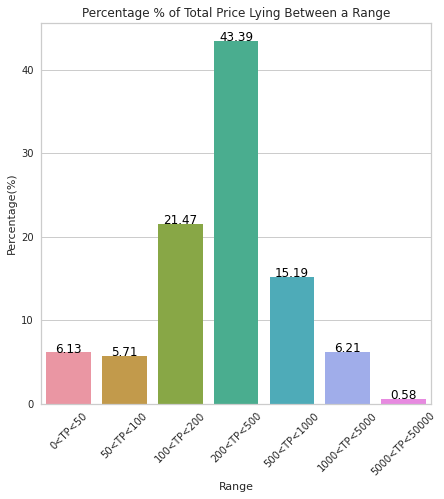

In [18]:
prcdata = pd.Series(tp_df['TotalPrice'])

tp_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
tp_values = []

for i, price in enumerate(tp_range):
    if i==0:
        continue
    tp_values.append(tp_df[(tp_df['TotalPrice']<price) & (tp_df['TotalPrice']>tp_range[i-1])]['TotalPrice'].count())
              
for i in range(len(tp_values)):
    tp_values[i] = (tp_values[i]/tp_df.shape[0])*100

str_rng = []
for i in range(1,len(tp_range)):
    str_rng.append("{}<TP<{}".format(tp_range[i-1],tp_range[i]))

plt.figure(figsize=(7,7))  
df_bar1 = pd.DataFrame({'Range':str_rng,'Percentage':tp_values})
b1 = sns.barplot(x='Range',y='Percentage',data=df_bar1)
b1.set_xticklabels(b1.get_xticklabels(),rotation=45)

b1.set_title('Percentage % of Total Price Lying Between a Range')
b1.set_ylabel('Percentage(%)')
for index, row in df_bar1.iterrows():
    b1.text(row.name,row.Percentage, round(row.Percentage,2), color='black', ha="center")
plt.show()

### <font color="green">Insights-6</font>
- Vast Majority of orders are associated with large TotalPrices as we can see that approximately **65%** of orders are above **200** Pound.


# <font color=blue>_Product Categories Insights_</font>

In [19]:
# check for noun(common, proper) appearing in the products description
def is_noun(pos):
    return pos[:2] == 'NN'

def extract_keywords(df, col = 'Description'):
    # defining the stemmer
    # stemmer removes morphological affix(word)+root=new word and will only keep the root 
    stemmer = nltk.stem.SnowballStemmer("english")
    # aggregate the set of names associated with a particular root
    keywords_roots  = dict()
    # associate root and keyword
    keywords_select = dict()
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    
    for s in df[col]:
        if pd.isnull(s): 
            continue
        # convert to lower-case    
        lines = s.lower()
        # tokenizes the words and punctuations 
        tokenized = nltk.word_tokenize(lines)
        # pos_tag tags words with part-of-speech and then checks for noun
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for n in nouns:
            #convert to lower string
            n = n.lower()
            #convert to base singular root word
            sroot = stemmer.stem(n)
            
            #add in dict if exists
            if sroot in keywords_roots:                
                keywords_roots[sroot].add(n)
                count_keywords[sroot] += 1                
            else: #create a new key
                keywords_roots[sroot] = {n}
                count_keywords[sroot] = 1
    
    # of all the keywords associated with the roots, find the keyword with shortest length
    for s in keywords_roots.keys():
        # number of keywords greater than one
        if len(keywords_roots[s]) > 1:  
            min_length = sys.maxsize
            #find the keyword with shortest length
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    keyw = k 
                    min_length = len(k)            
            category_keys.append(keyw)
            keywords_select[s] = keyw
        else:# if number of keywords is one
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    return category_keys, keywords_roots, keywords_select, count_keywords

In [20]:
keyword_df = pd.DataFrame(df['Description'].unique()).rename(columns={0:'Description'})
#call to function extract_keywords
keywords, keywords_roots, keywords_select, count_keywords = extract_keywords(keyword_df, col='Description')
print("Number of keywords in Description attribute:",len(keywords))

#convert dict to list
keyword_list = [keywords_select[i] for i in count_keywords.keys()]



LookupError: 
**********************************************************************
  Resource [93maveraged_perceptron_tagger[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtaggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle[0m

  Searched in:
    - '/home/hd3adpool/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
#dataFrame for Plot
df_bar2 = pd.DataFrame({'Keywords':keyword_list,'Frequency':count_keywords.values()})
df_bar2.sort_values(by=['Frequency'],ascending=False,inplace=True)

#display the top 50 keywords with their frequency    
plt.figure(figsize=(17,12))
b2 = sns.barplot(x='Frequency',y='Keywords',data=df_bar2[:50])
b2.set_yticklabels(b2.get_yticklabels(),fontsize=12)
b2.set_title("Keyword Occurence")
b2.set_ylabel("Keywords")
b2.set_xlabel('Number of Occurences')
plt.show()

## Types of Keywords

### <font color="green">Insights-7</font>
- On examining the keywords we find that, there are **94** keywords containing special characters.
- There are keywords like **pink, blue, tag, green, orange** this which does not carry information. Total of **5** keywords
- Keyword length **<2** are not relevant. e.g. **w,i,ma,st,la** and so on. Total of **803**

## Final Keywords

In [ ]:
final_keywords = []
# get key-value pair from the count_keywords dictionary
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']:
        continue
    # do not consider if word length less than 3
    # do not consider if the frequency of keyword less than 13
    if len(word) < 3 or v < 13:
        continue
    # do no consider if contains special characters
    if ('+' in word) or ('/' in word): 
        continue
    final_keywords.append([word, v])

print("Final Keywords kept:",len(final_keywords))

## Data Encoding: One-hot Encoding
- Columns of Matrix are the **193** Keywords.
- Rows of Matrix contains the products with unique description.

In [ ]:
unique_desc = df1['Description'].unique()
encod_mat = pd.DataFrame()

for key, count in final_keywords:
    encod_mat.loc[:,key] = list(map(lambda x:int(key.upper() in x),unique_desc))
    
print("One-hot encoded Matrix of Unique Description vs Keywords:")
display(encod_mat)

In [ ]:
# UnitPrice threshold ranges
unitp_thres = [0, 1, 2, 3, 5, 10]

# str to represent ranges
col_labels = []

for i in range(len(unitp_thres)):
    if i == len(unitp_thres)-1:
        col = 'UPR>{}'.format(unitp_thres[i])
    else:
        col = '{}<UPR<{}'.format(unitp_thres[i],unitp_thres[i+1])
    col_labels.append(col)
    encod_mat.loc[:, col] = 0
    
for i, desc in enumerate(unique_desc):
    mn_unitp = df1[df1['Description'] == desc]['UnitPrice'].mean()
    j = 0
    while mn_unitp > unitp_thres[j]:
        j+=1
        if j == len(unitp_thres): break
    encod_mat.loc[i, col_labels[j-1]] = 1

prod_dist = []    
for i in range(len(unitp_thres)):
    if i == len(unitp_thres)-1:
        col = 'UPR>{}'.format(unitp_thres[i])
    else:
        col = '{}<UPR<{}'.format(unitp_thres[i],unitp_thres[i+1])    
    prod_dist.append(encod_mat.loc[:,col].sum())

display(pd.DataFrame({'UnitPriceRange':col_labels,'NumberOfProducts':prod_dist}))

## KModes Clustering

In [ ]:
#check for optimal number of clustering.
# The Average silhouette score for 2 is: 0.12144691400412004
# The Average silhouette score for 3 is: 0.17773801606857215
# The Average silhouette score for 4 is: 0.22326403238760958
# The Average silhouette score for 5 is: 0.2602882515847933
# The Average silhouette score for 6 is: 0.2527632259663735
# The Average silhouette score for 7 is: 0.25322076363490587
# The Average silhouette score for 8 is: 0.23731255715846641
ncl = []
silhouette_s = []
cal_hara_s = [] 
for num_clusters in range(2,9):
    ncl.append(num_clusters)
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 10,n_jobs=8,random_state=42);
    cl = kmode.fit_predict(encod_mat);
    sc = silhouette_score(encod_mat,cl,metric='hamming')
    cal_hara_s.append(calinski_harabasz_score(encod_mat,cl))
    silhouette_s.append(sc)
    print('The Average silhouette score for',num_clusters,'is:',sc)

### <font color="green">Insights-8</font>
- Best metric for binary matrices is **Hamming's Metric**.
- Silhouette metric better than other Calinski Harabasz metric because of **higher dimensions** of data.
- We can see, the average silhouette score is highest for **5** clusters.
- Anything more than **5** clusters will result into uneven distribution of data.

In [ ]:
#visualizers for silhouette score and calinski harabasz score 
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

fig.suptitle('Optimal Cluster Visualization through Scores',fontsize=22)

l1 = sns.lineplot(ax=axes[0],data=pd.DataFrame({'Cluster':ncl,'Silhouette':silhouette_s}),x='Cluster',y='Silhouette',marker="o")
l1.set_title('Silhouette Score vs Clusters')
l1.set_ylabel('Silhouette Score')
l1.set_xlabel('Number of Clusters')

l2 = sns.lineplot(ax=axes[1],data=pd.DataFrame({'Cluster':ncl,'Calinski':cal_hara_s}),x='Cluster',y='Calinski',marker="o")
l2.set_title('Calinski Harabasz Score vs Clusters')
l2.set_ylabel('Calinski Harabasz Score')
l2.set_xlabel('Number of Clusters')

plt.show()

In [ ]:
#Clustering counts for five models.
n_clusters=5
fkmode = KModes(n_clusters=n_clusters, init = "Huang", n_init = 10,n_jobs=8, random_state = 42)
cl = fkmode.fit_predict(encod_mat)

print(cl.shape)
display(pd.DataFrame({'Class':pd.Series(cl).value_counts().index,'Frequency':pd.Series(cl).value_counts()}))


In [ ]:
#silhouette visualizer
sil_viz = SilhouetteVisualizer(fkmode)

sil_viz.fit(encod_mat)
sil_viz.poof()

## WordCloud Visualization

In [ ]:
#find out the frequency of keywords for every cluster
pro_df = pd.DataFrame(unique_desc)
pro_words = [word for (word, occurence) in final_keywords]
occurence = [dict() for _ in range(n_clusters)]
print(cl.shape)
for i in range(n_clusters):
    temp_clu = pro_df.loc[cl == i]
    for word in pro_words:
        # for cluster i and a word from 193 keywords find the occurence of a word for cluster i
        occurence[i][word] = sum(temp_clu.loc[:, 0].str.contains(word.upper()))

#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)   

### <font color="green">Insights-9</font>
- One of the clusters could be associated with **gifts(e.g. christmas, packaging, card,..)**
- One of the clusters could be associated with **luxury items and jewelry(e.g. necklace, bracelet, lace, silver,...)**
- Many words appear in multiple clusters and therefore **difficult to clearly distinguish them**.
- Different products were grouped into five clusters.
- Moreover, **PCA** can be used to ensure that these clusters are truly distinct.


# <font color=blue>*Customer Categories*</font>

## Embed Information into the dataset: _"ProductCategory"_ and _"AmountSpentPerCategory"_

In [ ]:
mp = {}
# map description to the cluster number
for key, value in zip(unique_desc, cl):
    mp[key] = value

# create a new variable in DataFrame "ProductCategory"    
df1['ProductCategory'] = df1.loc[:,'Description'].map(mp)

# add 5 new clusters
for i in range(n_clusters):
    newcol = 'Category{}'.format(i)
    tmp = df1[df1['ProductCategory']==i]
    pricet = tmp['UnitPrice']*(tmp['Quantity']-tmp['QuantityCanceled'])
    pricet = pricet.apply(lambda x:x if x > 0 else 0)
    df1.loc[:,newcol] = pricet
    df1[newcol].fillna(0,inplace=True)
    
# display new Variable for AmountSpentPerCategory
display(df1[['InvoiceNo', 'Description', 'ProductCategory', 'Category0', 'Category1', 'Category2', 'Category3','Category4']][:15])

## Merge Multiple Entries of _"One order"_ into _"One row"_

In [ ]:
# merge multiple entries of order into a single one

# join data using "CustomerID" and "InvoiceNo"
temp = df1.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
ordperrow = temp.rename(columns = {'TotalPrice':'BasketPrice'})

# sum "CategoryAmount" per cluster 
for i in range(n_clusters):
    col = 'Category{}'.format(i) 
    temp = df1.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    ordperrow.loc[:, col] = temp[col]

# take mean value of datetime for a particular order
df1['InvoiceDateInt'] = df1['InvoiceDate'].astype('int64')
temp = df1.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDateInt'].mean()

df1.drop('InvoiceDateInt', axis = 1, inplace = True)
ordperrow.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDateInt'])

# remove orders with "BasketPrice" <= 0
ordperrow = ordperrow[ordperrow['BasketPrice'] > 0]
print("DataFrame shape:",ordperrow.shape)

ordperrow.sort_values('BasketPrice', ascending = False)[:5]


## Test-Train Data Separation
- **ordperrow** contains data for period of **12 months**.
- In order to test the model in realistic way, use first **10 months for training, and last 2 months for testing**.

In [ ]:
# dataframe min and max invoice dates
print('DataFrame order start from:',ordperrow['InvoiceDate'].min())
print('DataFrame order end at:',ordperrow['InvoiceDate'].max())

In [ ]:
# split data into test and train
train_set = ordperrow[ordperrow['InvoiceDate'] < pd.to_datetime(datetime.date(2011,10,1))]
test_set = ordperrow[ordperrow['InvoiceDate'] >= pd.to_datetime(datetime.date(2011,10,1))]
ordperrow = train_set.copy(deep=True)

## Customer Order Combinations
- Group together different entries that correspond to the **same user**
- Determine **number of purchases, min, max, average amount, total_amount** from all visits.

In [ ]:
# join different entries correspoding to the same user
cus_df=ordperrow.groupby(by=['CustomerID'])['BasketPrice'].agg(['count','min','max','mean','sum'])

# percentage amount spend in a particular Category by a customer
for i in range(n_clusters):
    col = 'Category{}'.format(i)
    cus_df.loc[:,col] = (ordperrow.groupby(by=['CustomerID'])[col].sum()/cus_df['sum'])*100

cus_df.reset_index(drop = False, inplace = True)
ordperrow.groupby(by=['CustomerID'])['Category0'].sum()
cus_df.sort_values('CustomerID', ascending = True)[:5]
 

## Add Variables: *_FirstPurchase_* and *_LastPurchase_*

In [ ]:
ld = ordperrow['InvoiceDate'].max().date()

# find the first purchase and last purchase of every user
pf = pd.DataFrame(ordperrow.groupby(by=['CustomerID'])['InvoiceDate'].min())
pl = pd.DataFrame(ordperrow.groupby(by=['CustomerID'])['InvoiceDate'].max())

# number of days since first and last purchase
dpf = pf.applymap(lambda x:(ld-x.date()).days)
dpl = pl.applymap(lambda x:(ld-x.date()).days)

# add new variables
cus_df.loc[:,'LastPurchase'] = dpl.reset_index(drop=False)['InvoiceDate']
cus_df.loc[:,'FirstPurchase'] = dpf.reset_index(drop=False)['InvoiceDate']

# customer dataFrame
display(cus_df.head())

In [ ]:
# number of customers who only bought once
print('One time customers are:',cus_df[cus_df['count']==1].shape[0],',which are:',100*(cus_df[cus_df['count']==1].shape[0]/cus_df.shape[0]),'%')

### <font color="green">Insights-10</font>
- **40%** or **1445** of the customers only made one purchase.
- One of the objective can be to target these users to **retain them**.

## <font color="blue">_Categorize Customers_</font>

In [ ]:
#convert dataFrame to matrix by only using important columns
tmpc = cus_df.copy(deep=True)
tmpc.drop(['sum','CustomerID','LastPurchase','FirstPurchase'],axis=1,inplace=True)
cmat = tmpc.values

scaler = StandardScaler()
scaler.fit(cmat)

# different variables have different ranges and different variation
print('Mean Values of Attributes',scaler.mean_)

# standardize the data
cmat = scaler.transform(cmat)

## KMeans Clustering: Customer Categories

In [ ]:
#check for optimal number of clusters.
ncl = []
distor = []
silhouette_s = []
cal_hara_s = []
for num_clusters in range(3,20):
    ncl.append(num_clusters)
    kmean = KMeans(init='k-means++',n_clusters = num_clusters, n_init=100,random_state=42)
    kmean.fit(cmat)
    cl = kmean.fit_predict(cmat)
    sc = silhouette_score(cmat,cl)
    distor.append(kmean.inertia_)
    cal_hara_s.append(calinski_harabasz_score(cmat,cl))
    silhouette_s.append(sc)
    print('The Average silhouette score for',num_clusters,'is:',sc)

### <font color="green">Insights-11</font>
- KMeans instead of Kmode because as the **matrix is not binary**.
- We can see, the average silhouette score is highest for **11** clusters.
- The distinctness of the clusters can be verified using **PCA**.

In [ ]:
#visualizers for silhouette scores,distortions and calinski harabasz score 
fig, axes = plt.subplots(3, 1, figsize=(12, 20))

fig.suptitle('Optimal Cluster Visualization through Scores',fontsize=22)

l1 = sns.lineplot(ax=axes[0],data=pd.DataFrame({'Cluster':ncl,'Silhouette':silhouette_s}),x='Cluster',y='Silhouette',marker="o")
l1.set_title('Silhouette Score vs Clusters',fontsize=18)
l1.set_ylabel('Silhouette Score',fontsize=14)
l1.set_xlabel('Number of Clusters',fontsize=14)
l1.set_xticks(ncl)

l2 = sns.lineplot(ax=axes[1],data=pd.DataFrame({'Cluster':ncl,'Calinski':cal_hara_s}),x='Cluster',y='Calinski',marker="o")
l2.set_title('Calinski Harabasz Score vs Clusters',fontsize=18)
l2.set_ylabel('Calinski Harabasz Score',fontsize=14)
l2.set_xlabel('Number of Clusters',fontsize=14)
l2.set_xticks(ncl)

l3 = sns.lineplot(ax=axes[2],data=pd.DataFrame({'Cluster':ncl,'Distortion':distor}),x='Cluster',y='Distortion',marker="o")
l3.set_title('Distortion Score vs Clusters',fontsize=18)
l3.set_ylabel('Distotion Score',fontsize=14)
l3.set_xlabel('Number of Clusters',fontsize=14)
l3.set_xticks(ncl)

plt.show()

## Customer Distribution

In [ ]:
# customer distribution data
n_clusters=11
fkmean = KMeans(init='k-means++',n_clusters = n_clusters, n_init=100,random_state=42);
cl = fkmean.fit_predict(cmat)
display(pd.DataFrame({'Class':pd.Series(cl).value_counts().index,'Frequency':pd.Series(cl).value_counts()}))

In [ ]:
#silhouette visualizer
sil_viz = SilhouetteVisualizer(fkmean)

plt.figure(figsize=(10,10))
sil_viz.fit(cmat)
sil_viz.poof()


## Customer Morphotype 
- Understand the habits of the customers in each cluster

In [ ]:
# add new column of cluster Class
cus_df.loc[:,'Cluster'] = cl
cusmerge = pd.DataFrame()

for i in range(n_clusters):
    t = pd.DataFrame(cus_df[cus_df['Cluster']==i].mean())
    t = t.T.set_index('Cluster', drop = True)
    t['size'] = cus_df[cus_df['Cluster']==i].shape[0]
    cusmerge = pd.concat([cusmerge,t])

cusmerge.drop('CustomerID', axis = 1, inplace = True)
print('Total number of customers',cusmerge['size'].sum())

cusmerge = cusmerge.sort_values('sum',ascending=False)

list_ind = []
for i in range(5):
    column = 'Category{}'.format(i)
    list_ind.append(cusmerge[cusmerge[column] > 45].index.values[0])

list_ind_reorder = list_ind
list_ind_reorder += [ s for s in cusmerge.index if s not in list_ind]

cusmerge = cusmerge.reindex(index = list_ind_reorder)
cusmerge = cusmerge.reset_index(drop = False)
display(cusmerge[['Cluster', 'count', 'min', 'max', 'mean', 'sum', 'Category0',
                   'Category1', 'Category2', 'Category3', 'Category0', 'size']])

## Customer Morphology

In [ ]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) for x in grid]
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels = gridlabel, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)
        
fig = plt.figure(figsize=(12,14))

attributes = ['count', 'mean', 'sum', 'Category0', 'Category1', 'Category2', 'Category3', 'Category4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(cusmerge.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

### <font color="green">Insights-12</font>
- We can see that the first **5 clusters** correspond to a strong preponderance of **_purchases in a particular categories_.**
- Other clusters differ from **mean(Order Average), sum(Total Order Amount), and count(Number of Visits Made).

# <font color=blue>*Customer Classification*</font>

- **Objective**: Classification possible at first visit.
- In order to simplify the use of sklearn classifiers, we will create an class to interface several common functionalities.

In [ ]:
# interface class to classifiers
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    # using RandomizedSearchCV instead of GridSearchCV
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold,refit=True)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
    
    def get_grid_best_params(self):
        print("Best Parameters are",self.grid.best_params_)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*accuracy_score(Y, self.predictions)))

## Learning Curve Function
- It allows us to detect possible flaws in the model.

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title,fontsize=15)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Samples",fontsize=12)
    plt.ylabel("Scores",fontsize=12)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

- We will only keep variables that describe the content of the orders, and won't take into account variables such as frequency of visits or variations of the order price over time.

In [ ]:
# required attributes
cols = ['mean','Category0','Category1','Category2','Category3','Category4']
X = cus_df[cols]
y = cus_df['Cluster']

# split dataset into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

## SVM: RBF


In [ ]:
#svm hyper-parameter tuning
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

svc_rbf = Class_Fit(clf=SVC)
svc_rbf.grid_search(param_grid,Kfold=5)
svc_rbf.grid_fit(X_train,y_train)
svc_rbf.grid_predict(X_test,y_test)

svc_rbf.get_grid_best_params()



In [ ]:
# learning curve visualization
svc_rbf_g = plot_learning_curve(svc_rbf.grid.best_estimator_,
                        "SVC learning curves", X_train, y_train, ylim = [1.01, 0.6], cv = 5, train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9, 1])

### <font color="green">Insights-SVM</font>
- **No underfitting**:
- Other clusters differ from **mean(Order Average), sum(Total Order Amount), and count(Number of Visits Made).

## Logistic Regression

In [ ]:
#logistic Regression hyper-parameter tuning
param_grid = {'C':np.logspace(-2,2,20)} 

lr = Class_Fit(clf=LogisticRegression)
lr.grid_search(param_grid,Kfold=5)
lr.grid_fit(X_train,y_train)
lr.grid_predict(X_test,y_test)

lr.get_grid_best_params()


In [ ]:
# learning curve visualization
lr_g = plot_learning_curve(lr.grid.best_estimator_,
                        "Logistic Regression learning curves", X_train, y_train, ylim = [1.01, 0.6], cv = 5, train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9, 1])

## K-Nearest Neighbors

In [ ]:
#K-Nearest Neighbors hyper-parameter tuning
param_grid = {'n_neighbors': np.arange(1,50,1),'p':[1,2]} 

knn = Class_Fit(clf=KNeighborsClassifier)
knn.grid_search(param_grid,Kfold=5)
knn.grid_fit(X_train,y_train)
knn.grid_predict(X_test,y_test)

knn.get_grid_best_params()


In [ ]:
# learning curve visualization
knn_g = plot_learning_curve(knn.grid.best_estimator_,
                        "K-Nearest Neighbors learning curves", X_train, y_train, ylim = [1.01, 0.6], cv = 5, train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9, 1])

## Decision Tree

In [ ]:
#Decision Tree hyper-parameter tuning
param_grid = {'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}
dt = Class_Fit(clf=DecisionTreeClassifier)
dt.grid_search(param_grid,Kfold=5)
dt.grid_fit(X_train,y_train)
dt.grid_predict(X_test,y_test)

dt.get_grid_best_params()


In [ ]:
# learning curve visualization
dt_g = plot_learning_curve(dt.grid.best_estimator_,
                        "Decision Tree learning curves", X_train, y_train, ylim = [1.01, 0.6], cv = 5, train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9, 1])

## Random Forest Classifier

In [ ]:
#Random Forest Classifier hyper-parameter tuning
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],'max_features' :['sqrt', 'log2']}
rfc = Class_Fit(clf=RandomForestClassifier)
rfc.grid_search(param_grid,Kfold=5)
rfc.grid_fit(X_train,y_train)
rfc.grid_predict(X_test,y_test)

rfc.get_grid_best_params()


In [ ]:
# learning curve visualization
rfc_g = plot_learning_curve(rfc.grid.best_estimator_,
                        "Random Forest Classifier curves", X_train, y_train, ylim = [1.01, 0.6], cv = 5, train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9, 1])

## AdaBoost Classifier

In [ ]:
#AdaBoost Classifier hyper-parameter tuning
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
abc = Class_Fit(clf=AdaBoostClassifier)
abc.grid_search(param_grid,Kfold=5)
abc.grid_fit(X_train,y_train)
abc.grid_predict(X_test,y_test)

abc.get_grid_best_params()

In [ ]:
# learning curve visualization
abc_g = plot_learning_curve(abc.grid.best_estimator_,
                        "AdaBoost Classifier curves", X_train, y_train, ylim = [1.01, 0.4], cv = 5, train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9, 1])

## Gradient Boosting Classifier

In [ ]:
#Gradient Boosting Classifier hyper-parameter tuning
param_grid = {
    'n_estimators':[10,20,30,40,50,60,70,80,90,100]
}

gbc = Class_Fit(clf=GradientBoostingClassifier)
gbc.grid_search(param_grid,Kfold=5)
gbc.grid_fit(X_train,y_train)
gbc.grid_predict(X_test,y_test)

gbc.get_grid_best_params()

In [ ]:
# learning curve visualization
gbc_g = plot_learning_curve(gbc.grid.best_estimator_,
                        "Gradient Boosting Classifier curves", X_train, y_train, ylim = [1.01, 0.6], cv = 5, train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9, 1])

## Voting Classifier 

In [ ]:
rfcb  = RandomForestClassifier(**rfc.grid.best_params_)
gbcb  = GradientBoostingClassifier(**gbc.grid.best_params_)
knnb = KNeighborsClassifier(**knn.grid.best_params_)
lrb  = LogisticRegression(**lr.grid.best_params_)
dtb = DecisionTreeClassifier(**dt.grid.best_params_)
abcb = AdaBoostClassifier(**abc.grid.best_params_)

voting = VotingClassifier(estimators=[('rf',rfcb),('gb',gbcb),('knn',knnb),('lr',lrb)],voting='soft')
voting = voting.fit(X_train,y_train)
pred = voting.predict(X_test)

print("Precision: {:.2f} % ".format(100*accuracy_score(y_test, pred)))


# <font color=blue>*Prediction testing on last Two Months data*</font>

## Key Points
- Time difference between the training set and test set.
- We will update **sum** and **count** attributes to main test set **equivalent** to training set.
- Final matrix processing is similar to the one done in the training set.

In [ ]:
# same process as done in the training set above
test_f = test_set.copy(deep=True)

test_df = test_f.groupby(by=['CustomerID'])['BasketPrice'].agg(['count','min','max','mean','sum'])

for i in range(5):
    col = 'Category{}'.format(i)
    test_df.loc[:,col] = (test_f.groupby(by=['CustomerID'])[col].sum()/test_df['sum'])*100
    
test_df.reset_index(drop=False,inplace=True)
test_f.groupby(by=['CustomerID'])['Category0'].sum()

test_df['count'] = 5*test_df['count']
test_df['sum'] = test_df['count']*test_df['mean']

display(test_df.sort_values('CustomerID',ascending=True)[:5])

# keep the columns important to the classification
li_cols = ['count','min','max','mean','Category0','Category1','Category2','Category3','Category4']
test_mat = test_df[li_cols].values
# normalization of matrix
f_mat = scaler.transform(test_mat)

## Classification of TestData into 11 Clusters
- Each line in a matrix contains the **buying habits** of the customer.
- We still are preparing the test data.
- **Benchmark**: Classify test data into **11 Clusters** using the **KMeans** model used in the training set.
- These Cluster Classification values will act as the test data for the main classifier.
- **VotingClassifier** uses restricted variables that will be defined from the first purchase.
- Finally, we will compare the predictions of **VotingClassifier** with **BenchmarkKMeansModel**.

In [ ]:
# benchmark KMeans Model 
test_y = fkmean.predict(f_mat)

In [ ]:
vcols = ['mean','Category0','Category1','Category2','Category3','Category4']
test_X = test_df[vcols]

In [ ]:
# all the classifiers which were used in the training set
clsfiers = [(svc_rbf,'Suppport Vector Machine'),
            (lr,'Logistic Regression'),
            (knn,'KNearest Neighbors'),
            (dt,'Decision Tree'),
            (rfc,'Random Forest Classifier'),
            (abc,'AdaBoost Classifier'),
            (gbc,'Gradient Boosting Classifier')
           ]

cls_dic = {}
for clf, label in clsfiers:
    print(label)
    clf.grid_predict(test_X,test_y)
    print('------------------------------------------------')

In [ ]:
# final precision calculation of voting classifier
predictions = voting.predict(test_X)
print("Precision: {:.2f} % ".format(100*accuracy_score(test_y, predictions)))